# Train supervised model first to make sure that works

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import os

In [ ]:
import gc
import os
import random
import time
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
from tabulate import tabulate
import pandas as pd

# INFO messages are not printed.
# This must be run before loading other modules.
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "1"

In [ ]:
!pip install wandb
# !wandb login
!wandb login fc4589beb76e1cf379168090f5e8efeb206ec1d3 # (you can directly insert your api key here to automatically login everytime)
import wandb
from wandb.keras import WandbMetricsLogger

In [ ]:
# install TF addons if needed
try:
    import tensorflow_addons as tfa  # main package
except ModuleNotFoundError:
    %pip install tensorflow-addons
    import tensorflow_addons as tfa

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.1/612.1 kB 3.3 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [ ]:
# Connect to TPU

print("Tensorflow version " + tf.__version__)

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])  # TPU detection
    print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
    raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.TPUStrategy(tpu)
# clear_output()

Tensorflow version 2.12.0
Running on TPU  ['10.118.45.74:8470']


In [ ]:
IMG_SIZE = 224

def parse_label_train(serialized,image_shape=(496,504,1),bio_tensor_shape=(6,)):

    features = {'image': tf.io.FixedLenFeature([], tf.string), 'bio_tensor': tf.io.FixedLenFeature([], tf.string), 'path': tf.io.FixedLenFeature([], tf.string)}
    parsed_example = tf.io.parse_single_example(serialized=serialized, features=features)

    image = parsed_example['image']
    bio_tensor = parsed_example['bio_tensor']
    path = parsed_example['path']

    image = tf.io.decode_raw(image, tf.uint8)
    image = tf.reshape(image, shape=image_shape)
    image = tf.cast(image, tf.float32)
    image = tf.image.grayscale_to_rgb(image)
    image = tf.image.resize(image,[IMG_SIZE,IMG_SIZE])
    # image = image*2/255-1
    # image = img_scaling(image)

    bio_tensor = tf.io.decode_raw(bio_tensor, tf.int64)
    bio_tensor = tf.reshape(bio_tensor, shape=bio_tensor_shape)
    bio_tensor = tf.cast(bio_tensor, tf.float32)

    return image, bio_tensor

In [ ]:
def parse_test(serialized,image_shape=(496,504,1)):

    features = {'image': tf.io.FixedLenFeature([], tf.string), 'path': tf.io.FixedLenFeature([], tf.string)}
    parsed_example = tf.io.parse_single_example(serialized=serialized, features=features)

    image = parsed_example['image']
    path = parsed_example['path']

    image = tf.io.decode_raw(image, tf.uint8)
    image = tf.reshape(image, shape=image_shape)
    image = tf.cast(image, tf.float32)
    image = tf.image.grayscale_to_rgb(image)
    image = tf.image.resize(image,[IMG_SIZE,IMG_SIZE])
    # image = image/255
    # image = img_scaling(image)

    return image

In [ ]:
AUTOTUNE=tf.data.AUTOTUNE
label_train_files = tf.io.matching_files('gs://pixelvision/label_train/*.tfrec')
test_files = tf.io.matching_files('gs://pixelvision/test/*.tfrec')

def split_train_val(train_files, val_ratio=0.2):
    val_size = int(len(train_files) * val_ratio)
    val_files = train_files[:val_size]
    train_files = train_files[val_size:]
    return val_files, train_files

val_files, train_files = split_train_val(label_train_files)

print(f"Number of val_files: {len(val_files)}")
print(f"Number of train_files: {len(train_files)}")

print(f"Number of test_files: {len(test_files)}")

Number of val_files: 2
Number of train_files: 8
Number of test_files: 4


In [ ]:
import tensorflow_datasets as tfds

BATCH_SIZE = 128

train_shards = tf.data.Dataset.from_tensor_slices(train_files)
train_ds = train_shards.interleave(lambda x: tf.data.TFRecordDataset(x), num_parallel_calls=AUTOTUNE)
train_ds = train_ds.shuffle(buffer_size=1024)
train_ds = train_ds.map(parse_label_train, num_parallel_calls=AUTOTUNE)
train_ds = train_ds.batch(BATCH_SIZE, drop_remainder=True)
train_ds = train_ds.prefetch(AUTOTUNE)

val_shards = tf.data.Dataset.from_tensor_slices(val_files)
val_ds = val_shards.interleave(lambda x: tf.data.TFRecordDataset(x), num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(parse_label_train, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.batch(BATCH_SIZE, drop_remainder=True)
val_ds = val_ds.prefetch(AUTOTUNE)

test_shards = tf.data.Dataset.from_tensor_slices(test_files)
test_ds = test_shards.flat_map(lambda x: tf.data.TFRecordDataset(x))
test_ds = test_ds.map(parse_test)
test_ds = test_ds.batch(BATCH_SIZE)


255.0 0.0
255.0 0.0
255.0 0.0


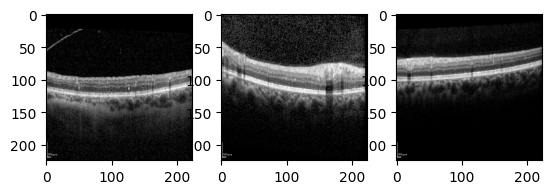

In [ ]:
fig, ax = plt.subplots(1,3)

for i in train_ds:
    print(np.max(i[0][0]), np.min(i[0][0]))
    ax[0].imshow(np.array(i[0][0]).astype(np.uint8))
    break

for i in val_ds:
    print(np.max(i[0][0]), np.min(i[0][0]))
    ax[1].imshow(np.array(i[0][0]).astype(np.uint8))
    break

for i in test_ds:
    print(np.max(i[0]), np.min(i[0]))
    ax[2].imshow(np.array(i[0]).astype(np.uint8))
    break

In [ ]:
with tpu_strategy.scope():
    backbone = tf.keras.applications.resnet_rs.ResNetRS50(
        include_top=False,
        weights=None,
        input_shape=(IMG_SIZE,IMG_SIZE,3),
        pooling='avg',
    )
    inputs = tf.keras.layers.Input((IMG_SIZE,IMG_SIZE,3))
    x = backbone(inputs, training=False)
    o = tf.keras.layers.Dense(6, activation="sigmoid")(x)
    model = tf.keras.Model(inputs, o)
    AUROC = tf.keras.metrics.AUC(curve='ROC', name = 'AUROC',multi_label = True)
    AUPRC = tf.keras.metrics.AUC(curve='PR', name = 'AUPRC',multi_label = True)
    model.compile(optimizer='adam', loss="binary_crossentropy", metrics=["acc", AUROC, AUPRC])

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=5, min_delta=0.05, mode='min')

In [ ]:
wandb.init(project='pixelvision',save_code=True)

model.fit(train_ds,
          validation_data=val_ds,
          epochs=50,
          callbacks=[callback])

Epoch 1/50
58/58 [==============================] - 100s 386ms/step - loss: 0.9815 - acc: 0.5131 - AUROC: 0.6211 - AUPRC: 0.5193 - val_loss: 0.5918 - val_acc: 0.7472 - val_AUROC: 0.6444 - val_AUPRC: 0.6135
Epoch 2/50
58/58 [==============================] - 9s 147ms/step - loss: 0.5790 - acc: 0.5753 - AUROC: 0.6937 - AUPRC: 0.6219 - val_loss: 0.5710 - val_acc: 0.7266 - val_AUROC: 0.6472 - val_AUPRC: 0.6308
Epoch 3/50
58/58 [==============================] - 9s 148ms/step - loss: 0.5439 - acc: 0.5978 - AUROC: 0.7378 - AUPRC: 0.6750 - val_loss: 0.5609 - val_acc: 0.7472 - val_AUROC: 0.7127 - val_AUPRC: 0.6558
Epoch 4/50
58/58 [==============================] - 9s 154ms/step - loss: 0.5031 - acc: 0.6358 - AUROC: 0.7712 - AUPRC: 0.7069 - val_loss: 0.5157 - val_acc: 0.7567 - val_AUROC: 0.7266 - val_AUPRC: 0.6726
Epoch 5/50
58/58 [==============================] - 9s 153ms/step - loss: 0.4566 - acc: 0.5583 - AUROC: 0.8236 - AUPRC: 0.7828 - val_loss: 0.4590 - val_acc: 0.7238 - val_AUROC: 0.801

In [ ]:
predictions = model.predict(test_ds)

31/31 [==============================] - 25s 378ms/step


In [ ]:
!curl https://raw.githubusercontent.com/olivesgatech/VIPCUP2023_OLIVES/main/csv_dir/test_set_submission_template.csv -o test_set_submission_template.csv

thresholds = [0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
predictions = (predictions>thresholds)*1
predictions = np.vstack((predictions,np.zeros((3,6))))

template = pd.read_csv('test_set_submission_template.csv')
template['B1']= predictions[:,0]
template['B2']= predictions[:,1]
template['B3']= predictions[:,2]
template['B4']= predictions[:,3]
template['B5']= predictions[:,4]
template['B6']= predictions[:,5]
template.to_csv('test_set_submission_template.csv', index=False)
template.head()

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  207k  100  207k    0     0   296k      0 --:--:-- --:--:-- --:--:--  296k


,Path (Trial/Image Type/Subject/Visit/Eye/Image Name),B1,B2,B3,B4,B5,B6
0,RECOVERY/OCT/01-037/W0/OS/RECOVERY0_000000.tif,0.0,0.0,1.0,0.0,0.0,0.0
1,RECOVERY/OCT/01-037/W0/OS/RECOVERY0_000001.tif,0.0,0.0,1.0,0.0,0.0,0.0
2,RECOVERY/OCT/01-037/W0/OS/RECOVERY0_000002.tif,0.0,0.0,1.0,0.0,0.0,0.0
3,RECOVERY/OCT/01-037/W0/OS/RECOVERY0_000003.tif,1.0,0.0,1.0,0.0,0.0,0.0
4,RECOVERY/OCT/01-037/W0/OS/RECOVERY0_000004.tif,1.0,0.0,1.0,0.0,0.0,0.0


# Start of Self supervised

# Imports

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import os

In [ ]:
import gc
import os
import random
import time
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
from tabulate import tabulate
import pandas as pd

# INFO messages are not printed.
# This must be run before loading other modules.
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "1"

In [ ]:
# install TF addons if needed
try:
    import tensorflow_addons as tfa  # main package
except ModuleNotFoundError:
    %pip install tensorflow-addons
    import tensorflow_addons as tfa

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.1/612.1 kB 6.4 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [ ]:
# install TF similarity if needed
try:
    import tensorflow_similarity as tfsim  # main package
except ModuleNotFoundError:
    %pip install tensorflow_similarity
    import tensorflow_similarity as tfsim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 230.4/230.4 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 kB 6.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 kB 5.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached pybind11-2.6.1-py2.py3-none-any.whl (188 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 8.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for nmslib: filename=nmslib-2.1.1-cp310-cp310-linux_x86_64.whl size=13578647 sha256=5670ccfafefd504d1507e16ed38d761900519cabee43f5ec55c56a4989d5559a
  Stored in directory: /root/.cache/pip/wheels/21/1a/5d/4cc754a5b1a88405cad184b76f823897a63a8d19afcd4b9314
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82808 sha256=6b986eee16bf48ddac2081071b28bfdfbfb267dd8241a1ee0b1081f6b34d1a77
  Stored in directory: /root/.cache/pip/wheels/a0/e8/c6/a37ea663620

In [ ]:
# Connect to TPU

print("Tensorflow version " + tf.__version__)

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])  # TPU detection
    print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
    raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.TPUStrategy(tpu)
# clear_output()

Tensorflow version 2.12.0
Running on TPU  ['10.78.129.186:8470']


In [ ]:
!pip install wandb
# !wandb login
!wandb login fc4589beb76e1cf379168090f5e8efeb206ec1d3 # (you can directly insert your api key here to automatically login everytime)
import wandb
from wandb.keras import WandbMetricsLogger, WandbModelCheckpoint

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.5/188.5 kB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 215.6/215.6 kB 10.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 6.7 MB/s eta 0:00:00
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8791 sha256=91ab024e06db84ac3f02818bfa02e98a9282189ac2c628e14b8f79c402c71711
  Stored in directory: /root/.cache/pip/wheels/e7/f3/22/152153d6eb222ee7a56ff8617d80ee5207207a8c00a7aab794
Successfully built pathtools
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


# Arguments

In [ ]:
ALGORITHM = "simclr"  # @param ["barlow", "simsiam", "simclr", "vicreg"]

In [ ]:
IMG_SIZE = 224
BATCH_SIZE = 128
PRE_TRAIN_EPOCHS = 200
TRAIN_EPOCHS = 20
# VAL_STEPS_PER_EPOCH = 20
WEIGHT_DECAY = 5e-4
WARMUP_LR = 0.0
WARMUP_STEPS = 0
TEMPERATURE = None

if ALGORITHM == "simsiam":
    INIT_LR = 3e-2 * int(BATCH_SIZE / 256)
elif ALGORITHM == "barlow":
    INIT_LR = 1e-3  # Initial LR for the learning rate schedule.
    WARMUP_STEPS = 1000
elif ALGORITHM == "simclr":
    INIT_LR = 1e-3  # Initial LR for the learning rate schedule, see section B.1 in the paper.
    TEMPERATURE = 0.1  # Tuned for CIFAR10, see section B.9 in the paper.
elif ALGORITHM == "vicreg":
    INIT_LR = 1e-3

# Parse functions

In [ ]:
def img_scaling(img):
    return tf.keras.applications.imagenet_utils.preprocess_input(
        img,
        data_format=None,
        mode='torch')


@tf.function
def simsiam_augmenter(img, blur=True, area_range=(0.2, 1.0)):
    """SimSiam augmenter.

    The SimSiam augmentations are based on the SimCLR augmentations, but have
    some important differences.
    * The crop area lower bound is 20% instead of 8%.
    * The color jitter and grayscale are applied separately instead of together.
    * The color jitter ranges are much smaller.
    * Blur is not applied for the cifar10 dataset.

    args:
        img: Single image tensor of shape (H, W, C)
        blur: If true, apply blur. Should be disabled for cifar10.
        area_range: The upper and lower bound of the random crop percentage.

    returns:
        A single image tensor of shape (H, W, C) with values between 0.0 and 1.0.
    """
    # random resize and crop. Increase the size before we crop.
    img = tfsim.augmenters.augmentation_utils.cropping.crop_and_resize(
        img, IMG_SIZE, IMG_SIZE, area_range=area_range
    )

    # The following transforms expect the data to be [0, 1]
    img /= 255.

    # random color jitter
    def _jitter_transform(x):
        return tfsim.augmenters.augmentation_utils.color_jitter.color_jitter_rand(
            x,
            np.random.uniform(0.0, 0.4),
            np.random.uniform(0.0, 0.4),
            np.random.uniform(0.0, 0.4),
            np.random.uniform(0.0, 0.1),
            "multiplicative",
        )

    img = tfsim.augmenters.augmentation_utils.random_apply.random_apply(_jitter_transform, p=0.8, x=img)

    # random grayscale
    def _grascayle_transform(x):
        return tfsim.augmenters.augmentation_utils.color_jitter.to_grayscale(x)

    img = tfsim.augmenters.augmentation_utils.random_apply.random_apply(_grascayle_transform, p=0.2, x=img)

    # optional random gaussian blur
    if blur:
        img = tfsim.augmenters.augmentation_utils.blur.random_blur(img, p=0.5)

    # random horizontal flip
    img = tf.image.random_flip_left_right(img)

    # scale the data back to [0, 255]
    img = img * 255.
    img = tf.clip_by_value(img, 0., 255.)

    return img

@tf.function()
def parse_unlabel_train(serialized,image_shape=(496,504,1),clinical_tensor_shape=(4,)):

    features = {'image': tf.io.FixedLenFeature([], tf.string), 'path': tf.io.FixedLenFeature([], tf.string), 'clinical_tensor': tf.io.FixedLenFeature([], tf.string)}
    parsed_example = tf.io.parse_single_example(serialized=serialized, features=features)

    image = parsed_example['image']
    path = parsed_example['path']
    clinical_tensor = parsed_example['clinical_tensor']

    image = tf.io.decode_raw(image, tf.uint8)
    image = tf.reshape(image, shape=image_shape)
    image = tf.image.grayscale_to_rgb(image)

    clinical_tensor = tf.io.decode_raw(clinical_tensor, tf.int64)
    clinical_tensor = tf.reshape(clinical_tensor, shape=clinical_tensor_shape)

    view1 = simsiam_augmenter(image, blur=False)
    # view1 = img_scaling(view1)
    view2 = simsiam_augmenter(image, blur=False)
    # view2 = img_scaling(view2)
    return (view1, view2)

In [ ]:
def parse_label_train(serialized,image_shape=(496,504,1),bio_tensor_shape=(6,)):

    features = {'image': tf.io.FixedLenFeature([], tf.string), 'bio_tensor': tf.io.FixedLenFeature([], tf.string), 'path': tf.io.FixedLenFeature([], tf.string)}
    parsed_example = tf.io.parse_single_example(serialized=serialized, features=features)

    image = parsed_example['image']
    bio_tensor = parsed_example['bio_tensor']
    path = parsed_example['path']

    image = tf.io.decode_raw(image, tf.uint8)
    image = tf.reshape(image, shape=image_shape)
    image = tf.cast(image, tf.float32)
    image = tf.image.grayscale_to_rgb(image)
    image = tf.image.resize(image,[IMG_SIZE,IMG_SIZE])
    # image = img_scaling(image)

    bio_tensor = tf.io.decode_raw(bio_tensor, tf.int64)
    bio_tensor = tf.reshape(bio_tensor, shape=bio_tensor_shape)

    return image, bio_tensor

In [ ]:
def parse_test(serialized,image_shape=(496,504,1)):

    features = {'image': tf.io.FixedLenFeature([], tf.string), 'path': tf.io.FixedLenFeature([], tf.string)}
    parsed_example = tf.io.parse_single_example(serialized=serialized, features=features)

    image = parsed_example['image']
    path = parsed_example['path']

    image = tf.io.decode_raw(image, tf.uint8)
    image = tf.reshape(image, shape=image_shape)
    image = tf.cast(image, tf.float32)
    image = tf.image.grayscale_to_rgb(image)
    image = tf.image.resize(image,[IMG_SIZE,IMG_SIZE])
    # image = img_scaling(image)

    return image

In [ ]:
def parse_testwpaths(serialized,image_shape=(496,504,1)):

    features = {'image': tf.io.FixedLenFeature([], tf.string), 'path': tf.io.FixedLenFeature([], tf.string)}
    parsed_example = tf.io.parse_single_example(serialized=serialized, features=features)

    image = parsed_example['image']
    path = parsed_example['path']

    image = tf.io.decode_raw(image, tf.uint8)
    image = tf.reshape(image, shape=image_shape)
    image = tf.cast(image, tf.float32)
    image = tf.image.grayscale_to_rgb(image)
    image = tf.image.resize(image,[IMG_SIZE,IMG_SIZE])
    # image = img_scaling(image)

    return image, path

# Dataset creation

In [ ]:
AUTOTUNE=tf.data.AUTOTUNE
unlabel_train_files = tf.io.matching_files('gs://pixelvision/unlabel_train/*.tfrec')
label_train_files = tf.io.matching_files('gs://pixelvision/label_train/*.tfrec')
test_files = tf.io.matching_files('gs://pixelvision/test/*.tfrec')

def split_train_val(train_files, val_ratio=0.1):
    val_size = int(len(train_files) * val_ratio)
    val_files = train_files[:val_size]
    train_files = train_files[val_size:]
    return val_files, train_files

preval_files, pretrain_files = split_train_val(unlabel_train_files)
val_files, train_files = split_train_val(label_train_files)

print(f"Number of preval_files: {len(preval_files)}")
print(f"Number of pretrain_files: {len(pretrain_files)}")

print(f"Number of val_files: {len(val_files)}")
print(f"Number of train_files: {len(train_files)}")

print(f"Number of test_files: {len(test_files)}")

Number of preval_files: 5
Number of pretrain_files: 45
Number of val_files: 1
Number of train_files: 9
Number of test_files: 4


In [ ]:
if ALGORITHM == "simsiam":
    pretrain_shards = tf.data.Dataset.from_tensor_slices(pretrain_files)
    pretrain_ds = pretrain_shards.interleave(lambda x: tf.data.TFRecordDataset(x), num_parallel_calls=AUTOTUNE)
    pretrain_ds = pretrain_ds.map(parse_unlabel_train, num_parallel_calls=AUTOTUNE)
    pretrain_ds = pretrain_ds.batch(BATCH_SIZE)

    PRE_TRAIN_STEPS_PER_EPOCH = 0
    for i in pretrain_ds:
        PRE_TRAIN_STEPS_PER_EPOCH+=i[0].shape[0]
    PRE_TRAIN_STEPS_PER_EPOCH = PRE_TRAIN_STEPS_PER_EPOCH // BATCH_SIZE

    preval_shards = tf.data.Dataset.from_tensor_slices(preval_files)
    preval_ds = preval_shards.interleave(lambda x: tf.data.TFRecordDataset(x), num_parallel_calls=AUTOTUNE)
    preval_ds = preval_ds.map(parse_unlabel_train, num_parallel_calls=AUTOTUNE)
    preval_ds = preval_ds.batch(BATCH_SIZE)

    PRE_VAL_STEPS_PER_EPOCH = 0
    for i in preval_ds:
        PRE_VAL_STEPS_PER_EPOCH+=i[0].shape[0]
    PRE_VAL_STEPS_PER_EPOCH = PRE_VAL_STEPS_PER_EPOCH // BATCH_SIZE

    train_shards = tf.data.Dataset.from_tensor_slices(train_files)
    train_ds = train_shards.interleave(lambda x: tf.data.TFRecordDataset(x), num_parallel_calls=AUTOTUNE)
    train_ds = train_ds.map(parse_label_train, num_parallel_calls=AUTOTUNE)
    train_ds = train_ds.batch(BATCH_SIZE)

    TRAIN_STEPS_PER_EPOCH = 0
    for i in train_ds:
        TRAIN_STEPS_PER_EPOCH+=i[0].shape[0]
    TRAIN_STEPS_PER_EPOCH = TRAIN_STEPS_PER_EPOCH // BATCH_SIZE

In [ ]:
import tensorflow_datasets as tfds

pretrain_shards = tf.data.Dataset.from_tensor_slices(pretrain_files)
pretrain_ds = pretrain_shards.interleave(lambda x: tf.data.TFRecordDataset(x), num_parallel_calls=AUTOTUNE)
# pretrain_ds = pretrain_ds.repeat()
pretrain_ds = pretrain_ds.shuffle(buffer_size=1024)
pretrain_ds = pretrain_ds.map(parse_unlabel_train, num_parallel_calls=AUTOTUNE)
pretrain_ds = pretrain_ds.batch(BATCH_SIZE, drop_remainder=True)
pretrain_ds = pretrain_ds.prefetch(AUTOTUNE)

preval_shards = tf.data.Dataset.from_tensor_slices(preval_files)
preval_ds = preval_shards.interleave(lambda x: tf.data.TFRecordDataset(x), num_parallel_calls=AUTOTUNE)
# preval_ds = preval_ds.repeat()
# preval_ds = preval_ds.shuffle(buffer_size=1024)
preval_ds = preval_ds.map(parse_unlabel_train, num_parallel_calls=AUTOTUNE)
preval_ds = preval_ds.batch(BATCH_SIZE, drop_remainder=True)
preval_ds = preval_ds.prefetch(AUTOTUNE)

train_shards = tf.data.Dataset.from_tensor_slices(train_files)
train_ds = train_shards.interleave(lambda x: tf.data.TFRecordDataset(x), num_parallel_calls=AUTOTUNE)
# train_ds = train_ds.repeat()
train_ds = train_ds.shuffle(buffer_size=1024)
train_ds = train_ds.map(parse_label_train, num_parallel_calls=AUTOTUNE)
train_ds = train_ds.batch(BATCH_SIZE, drop_remainder=True)
train_ds = train_ds.prefetch(AUTOTUNE)

val_shards = tf.data.Dataset.from_tensor_slices(val_files)
val_ds = val_shards.interleave(lambda x: tf.data.TFRecordDataset(x), num_parallel_calls=AUTOTUNE)
# val_ds = val_ds.repeat()
# val_ds = val_ds.shuffle(buffer_size=1024)
val_ds = val_ds.map(parse_label_train, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.batch(BATCH_SIZE, drop_remainder=True)
val_ds = val_ds.prefetch(AUTOTUNE)


test_shards = tf.data.Dataset.from_tensor_slices(test_files)
test_ds = test_shards.flat_map(lambda x: tf.data.TFRecordDataset(x))
test_ds = test_ds.map(parse_test)
test_ds = test_ds.batch(BATCH_SIZE)

0.0 255.0


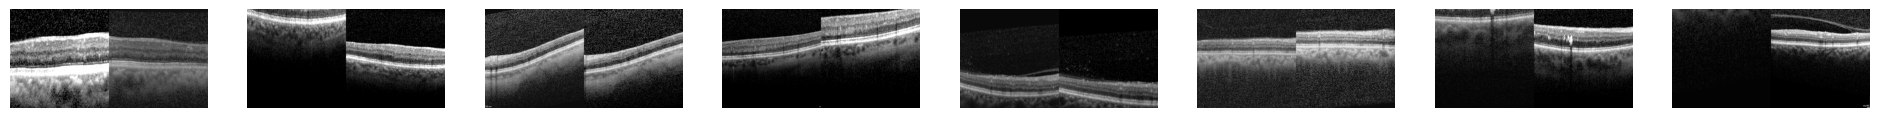

0.0 255.0


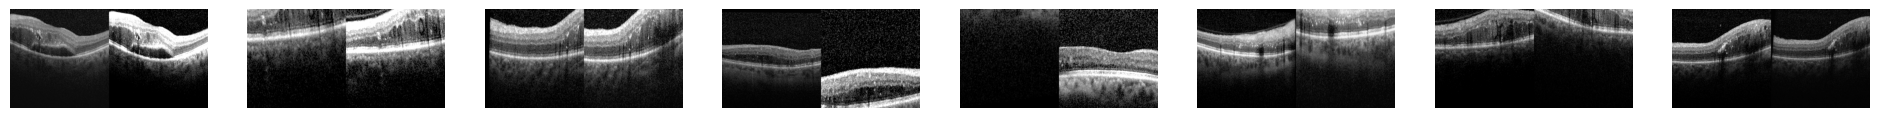

0.0 255.0


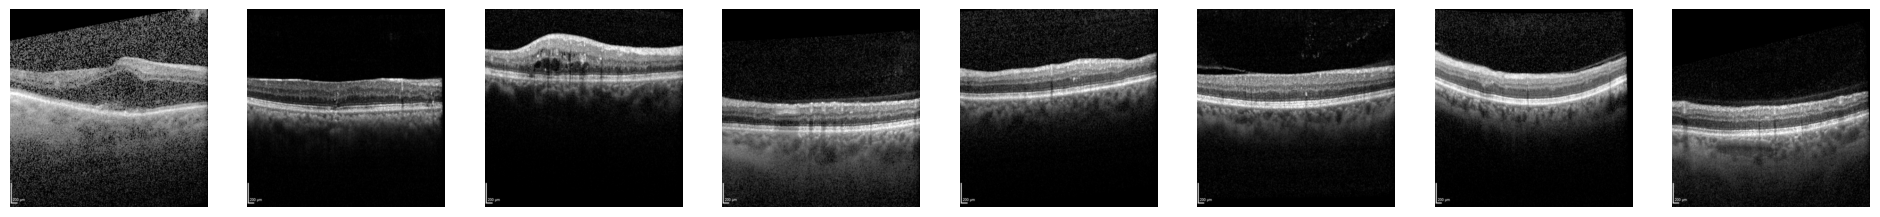

0.0 255.0


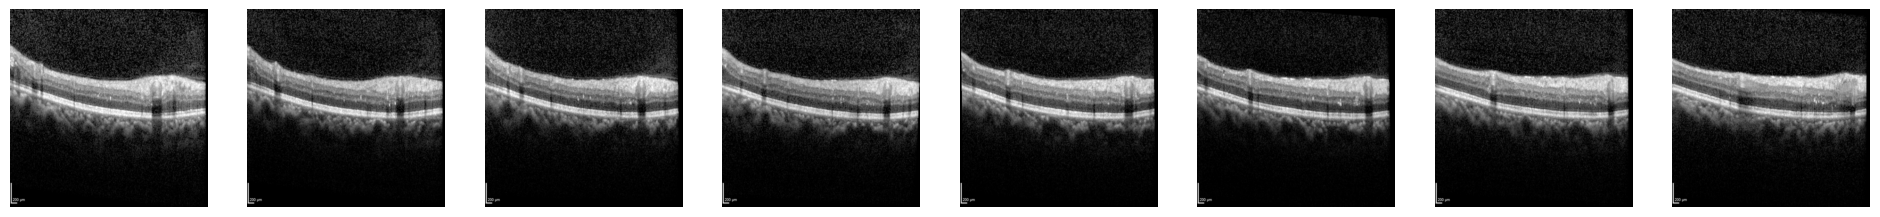

0.0 255.0


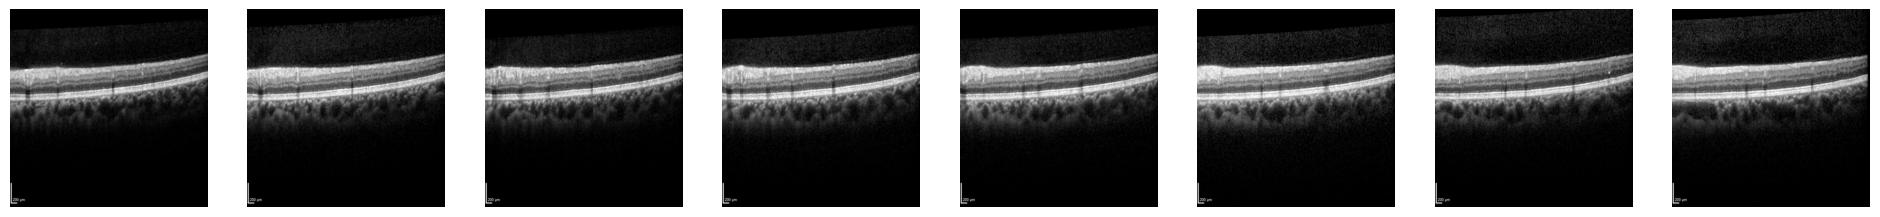

In [ ]:
display_imgs = next(pretrain_ds.as_numpy_iterator())
max_pixel = display_imgs[0].max()
min_pixel = display_imgs[0].min()
print(min_pixel,max_pixel)

tfsim.visualization.visualize_views(
    views=display_imgs,
    num_imgs=8,
    views_per_col=8,
    max_pixel_value=max_pixel,
    min_pixel_value=min_pixel,
)

display_imgs = next(preval_ds.as_numpy_iterator())
max_pixel = display_imgs[0].max()
min_pixel = display_imgs[0].min()
print(min_pixel,max_pixel)

tfsim.visualization.visualize_views(
    views=display_imgs,
    num_imgs=8,
    views_per_col=8,
    max_pixel_value=max_pixel,
    min_pixel_value=min_pixel,
)


display_imgs = next(train_ds.as_numpy_iterator())
max_pixel = display_imgs[0].max()
min_pixel = display_imgs[0].min()
print(min_pixel,max_pixel)

tfsim.visualization.visualize_views(
    views=[display_imgs[0]],
    num_imgs=8,
    views_per_col=8,
    max_pixel_value=max_pixel,
    min_pixel_value=min_pixel,
)

display_imgs = next(val_ds.as_numpy_iterator())
max_pixel = display_imgs[0].max()
min_pixel = display_imgs[0].min()
print(min_pixel,max_pixel)

tfsim.visualization.visualize_views(
    views=[display_imgs[0]],
    num_imgs=8,
    views_per_col=8,
    max_pixel_value=max_pixel,
    min_pixel_value=min_pixel,
)

display_imgs = next(test_ds.as_numpy_iterator())
max_pixel = display_imgs.max()
min_pixel = display_imgs.min()
print(min_pixel,max_pixel)

tfsim.visualization.visualize_views(
    views=[display_imgs],
    num_imgs=8,
    views_per_col=8,
    max_pixel_value=max_pixel,
    min_pixel_value=min_pixel,
)


# Model Architecture

In [ ]:
def get_backbone(img_size):
    input_shape = (img_size, img_size, 3)

    # backbone = tfsim.architectures.ResNet18Sim(
    #     input_shape,
    #     include_top=False,  # Take the pooling layer as the output.
    #     pooling="avg",
    # )

    backbone = tf.keras.applications.resnet_rs.ResNetRS50(
        include_top=False,
        weights=None,
        input_shape=input_shape,
        pooling='avg',
    )
    return backbone

def get_projector(input_dim):
    i = tf.keras.layers.Input((input_dim,), name="projector_input")
    x = tf.keras.layers.Dense(512, activation = 'swish')(i)
    # x = tf.keras.layers.BatchNormalization(epsilon=1.001e-5, name=f"batch_normalization_{i}")(x)

    # Metric Logging layer. Monitors the std of the layer activations.
    # Degnerate solutions colapse to 0 while valid solutions will move
    # towards something like 0.0220. The actual number will depend on the layer size.
    o = tfsim.layers.ActivationStdLoggingLayer(name="proj_std")(x)
    projector = tf.keras.Model(i, o, name="projector")
    return projector


# Uncomment to build a custom predictor.
# def get_predictor(input_dim, hidden_dim=512, activation="relu"):
#     inputs = tf.keras.layers.Input(shape=(input_dim,), name="predictor_input")
#     x = inputs

#     x = tf.keras.layers.Dense(
#         hidden_dim,
#         use_bias=False,
#         kernel_initializer=tf.keras.initializers.LecunUniform(),
#         name="predictor_layer_0",
#     )(x)
#     x = tf.keras.layers.BatchNormalization(epsilon=1.001e-5, name="batch_normalization_0")(x)
#     x = tf.keras.layers.Activation(activation, name=f"{activation}_activation_0")(x)

#     x = tf.keras.layers.Dense(
#         input_dim,
#         kernel_initializer=tf.keras.initializers.LecunUniform(),
#         name="predictor_output",
#     )(x)
#     # Metric Logging layer. Monitors the std of the layer activations.
#     # Degnerate solutions colapse to 0 while valid solutions will move
#     # towards something like 0.0220. The actual number will depend on the layer size.
#     o = tfsim.layers.ActivationStdLoggingLayer(name="pred_std")(x)
#     predictor = tf.keras.Model(inputs, o, name="predictor")
#     return predictor


# predictor = get_predictor(input_dim=DIM, hidden_dim=512)
# predictor.summary()

# Compile

In [ ]:
with tpu_strategy.scope():

    backbone = get_backbone(IMG_SIZE)
    projector = get_projector(input_dim=backbone.output.shape[-1])
    # projector = None
    predictor = None # Passing None will automatically build the default predictor.

    contrastive_model = tfsim.models.create_contrastive_model(
        backbone=backbone,
        projector=projector,
        predictor=predictor,
        algorithm=ALGORITHM,
        name=ALGORITHM,
    )

    if ALGORITHM == "simsiam":
        loss = tfsim.losses.SimSiamLoss(projection_type="cosine_distance", name=ALGORITHM)
        lr_decayed_fn = tf.keras.optimizers.schedules.CosineDecay(
            initial_learning_rate=INIT_LR,
            decay_steps=PRE_TRAIN_EPOCHS * PRE_TRAIN_STEPS_PER_EPOCH,
        )
        wd_decayed_fn = tf.keras.optimizers.schedules.CosineDecay(
            initial_learning_rate=WEIGHT_DECAY,
            decay_steps=PRE_TRAIN_EPOCHS * PRE_TRAIN_STEPS_PER_EPOCH,
        )
        optimizer = tfa.optimizers.SGDW(learning_rate=lr_decayed_fn, weight_decay=wd_decayed_fn, momentum=0.9)
    elif ALGORITHM == "barlow":
        loss = tfsim.losses.Barlow(name=ALGORITHM)
        optimizer = tfa.optimizers.LAMB(learning_rate=INIT_LR)
    elif ALGORITHM == "simclr":
        loss = tfsim.losses.SimCLRLoss(name=ALGORITHM, temperature=TEMPERATURE)
        optimizer = tfa.optimizers.LAMB(learning_rate=INIT_LR)
    elif ALGORITHM == "vicreg":
        loss = tfsim.losses.VicReg(name=ALGORITHM)
        optimizer = tfa.optimizers.LAMB(learning_rate=INIT_LR)
    else:
        raise ValueError(f"{ALGORITHM} is not supported.")

    contrastive_model.compile(
        optimizer=optimizer,
        loss=loss
    )

# print(contrastive_model.summary())
# tf.keras.utils.plot_model(contrastive_model, to_file='model.png', show_shapes=True, expand_nested=False)

# Pretrain

In [ ]:
from datetime import datetime
filestring = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')

tf.io.gfile.makedirs('gs://pixelvision/saved_models/'+ filestring)

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='gs://pixelvision/saved_models/'+ filestring+'/',
    save_weights_only=True,
    freq='epoch')

print(filestring)

2023-08-24_19-33-02


In [ ]:
# wandb.init(project='pixelvision',save_code=True)

contrastive_model.fit(
    pretrain_ds,
    epochs=PRE_TRAIN_EPOCHS,
    validation_data=preval_ds,
    callbacks = [model_checkpoint_callback]
)

Epoch 1/200
549/549 [==============================] - 553s 739ms/step - loss: 0.3811 - proj_std: 0.0351 - val_loss: 0.4599 - val_proj_std: 0.0269
Epoch 2/200
549/549 [==============================] - 381s 691ms/step - loss: 0.1553 - proj_std: 0.0295 - val_loss: 0.4537 - val_proj_std: 0.0218
Epoch 3/200
376/549 [===================>..........] - ETA: 1:51 - loss: 0.1361 - proj_std: 0.0263

# Save model

In [ ]:
# contrastive_model.save_weights('gs://pixelvision/saved_models/'+ filestring+'/')

In [ ]:
tf.io.gfile.makedirs('gs://pixelvision/saved_models/'+ filestring+'/backbone')

In [ ]:
contrastive_model.backbone.save_weights('gs://pixelvision/saved_models/'+ filestring+'/backbone/')

# Train

In [ ]:
with tpu_strategy.scope():
    backbone = tf.keras.applications.resnet_rs.ResNetRS50(
        include_top=False,
        weights='gs://pixelvision/saved_models/'+ filestring+'/backbone/',
        input_shape=(IMG_SIZE,IMG_SIZE,3),
        pooling='avg',
    )
    inputs = tf.keras.layers.Input((IMG_SIZE,IMG_SIZE,3))
    x = backbone(inputs, training=False)
    o = tf.keras.layers.Dense(6, activation="sigmoid")(x)
    model = tf.keras.Model(inputs, o)
    AUROC = tf.keras.metrics.AUC(curve='ROC', name = 'AUROC',multi_label = True)
    AUPRC = tf.keras.metrics.AUC(curve='PR', name = 'AUPRC',multi_label = True)
    model.compile(optimizer='adam', loss="binary_crossentropy", metrics=["acc", AUROC, AUPRC])

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=5, min_delta=0.05, mode='min')

In [ ]:
wandb.init(project='pixelvision',save_code=True)

model.fit(train_ds,
          validation_data=val_ds,
          epochs=50,
          callbacks=[callback, WandbMetricsLogger()])

Epoch 1/10
58/58 [==============================] - 119s 385ms/step - loss: 1.5982 - acc: 0.5067 - AUROC: 0.5699 - AUPRC: 0.4693 - val_loss: 0.6058 - val_acc: 0.7076 - val_AUROC: 0.6263 - val_AUPRC: 0.5970
Epoch 2/10
58/58 [==============================] - 11s 179ms/step - loss: 0.5679 - acc: 0.5890 - AUROC: 0.7050 - AUPRC: 0.6390 - val_loss: 0.6132 - val_acc: 0.5826 - val_AUROC: 0.6403 - val_AUPRC: 0.6334
Epoch 3/10
58/58 [==============================] - 9s 152ms/step - loss: 0.5313 - acc: 0.5998 - AUROC: 0.7438 - AUPRC: 0.6846 - val_loss: 0.5065 - val_acc: 0.7528 - val_AUROC: 0.6965 - val_AUPRC: 0.6596
Epoch 4/10
58/58 [==============================] - 9s 156ms/step - loss: 0.4846 - acc: 0.6210 - AUROC: 0.7929 - AUPRC: 0.7381 - val_loss: 0.4538 - val_acc: 0.5798 - val_AUROC: 0.7878 - val_AUPRC: 0.7372
Epoch 5/10
58/58 [==============================] - 10s 158ms/step - loss: 0.4588 - acc: 0.5591 - AUROC: 0.8133 - AUPRC: 0.7603 - val_loss: 0.4085 - val_acc: 0.6038 - val_AUROC: 0.8

# Threshold moving

In [ ]:
import numpy as np

train_shards = tf.data.Dataset.from_tensor_slices(train_files)
train_ds = train_shards.flat_map(lambda x: tf.data.TFRecordDataset(x))
train_ds = train_ds.map(parse_label_train)
train_ds = train_ds.batch(BATCH_SIZE)

y_true = np.empty((0,6))
for i in train_ds:
    y_true = np.vstack((y_true,i[1]))

Exception ignored in: <function Executor.__del__ at 0x7dafb27b8310>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


In [ ]:
y_pred = model.predict(train_ds)

59/59 [==============================] - 5s 64ms/step


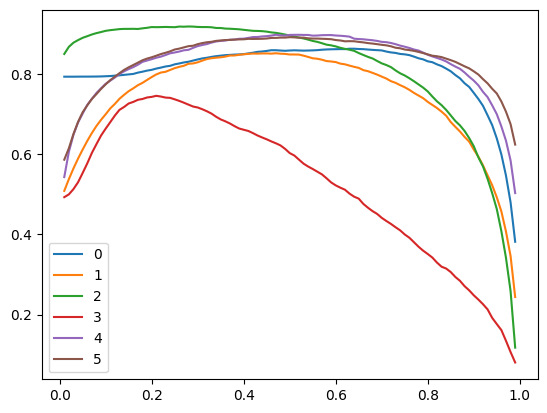

In [ ]:
threshold_moving = np.empty((0,6))
ran = np.arange(0.01,1,0.01)
thresholds = [0, 0, 0, 0, 0, 0]
for t in ran:
    metric = tfa.metrics.F1Score(num_classes=6, threshold=t)
    metric.update_state(y_true, y_pred)
    result = metric.result()
    threshold_moving = np.vstack((threshold_moving,result.numpy()))

for i in range(6):
    plt.plot(ran,threshold_moving[:,i])
plt.legend(range(6))
plt.show()

thresholds = ran[np.argmax(threshold_moving,axis=0,keepdims=True)]


# Test prediction and csv creation

In [ ]:
predictions = model.predict(test_ds)

31/31 [==============================] - 3s 64ms/step


In [ ]:
!curl https://raw.githubusercontent.com/olivesgatech/VIPCUP2023_OLIVES/main/csv_dir/test_set_submission_template.csv -o test_set_submission_template.csv

# thresholds = [0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
predictions = (predictions>thresholds)*1
predictions = np.vstack((predictions,np.zeros((3,6))))

template = pd.read_csv('test_set_submission_template.csv')
template['B1']= predictions[:,0]
template['B2']= predictions[:,1]
template['B3']= predictions[:,2]
template['B4']= predictions[:,3]
template['B5']= predictions[:,4]
template['B6']= predictions[:,5]
template.to_csv('test_set_submission_template.csv', index=False)
template.head()

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  207k  100  207k    0     0   821k      0 --:--:-- --:--:-- --:--:--  824k


,Path (Trial/Image Type/Subject/Visit/Eye/Image Name),B1,B2,B3,B4,B5,B6
0,RECOVERY/OCT/01-037/W0/OS/RECOVERY0_000000.tif,0.0,0.0,1.0,0.0,0.0,0.0
1,RECOVERY/OCT/01-037/W0/OS/RECOVERY0_000001.tif,1.0,0.0,1.0,0.0,0.0,0.0
2,RECOVERY/OCT/01-037/W0/OS/RECOVERY0_000002.tif,0.0,0.0,0.0,0.0,0.0,0.0
3,RECOVERY/OCT/01-037/W0/OS/RECOVERY0_000003.tif,0.0,0.0,1.0,0.0,0.0,0.0
4,RECOVERY/OCT/01-037/W0/OS/RECOVERY0_000004.tif,1.0,0.0,1.0,0.0,0.0,0.0
